In [5]:
import torch
import numpy as np
import os
from itertools import combinations
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.nn.utils import clip_grad_norm_
import pandas as pd

import optuna
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import optuna.visualization as vis

from ../src/datasets import BaseAntibodyDataset, WarmupDataset

from ../src/training_funcs import train_one_epoch, evaluate, warmup_train, cross_validate_with_pretrained

from ../src/models import AntibodyModel2, AntibodyModel3, AntibodyModel4, AntibodyModel5


In [6]:
device='cpu'

dataset = BaseAntibodyDataset('test_embeddings2.npy', 'test_DSP_out.npy')
dataset2 = BaseAntibodyDataset('train_embeddings2.npy', 'train_DSP_out.npy')

for fold in range(5):
    for model_, model_class in zip([2, 3, 4, 5], [AntibodyModel2, AntibodyModel3, AntibodyModel4, AntibodyModel5]):
        for task in range(5):

            loader = DataLoader(dataset, collate_fn=collate_batch)
            loader2 = DataLoader(dataset2, collate_fn=collate_batch)

            model = model_class(output_dim=1)
            model.eval()
            
            state_dict = torch.load(f'../outputs/cv_fold_{fold}_model{model_}_{task}.pt', map_location=device)
            model.load_state_dict(state_dict)

            preds = []
            for embeds, descs, labels in loader:
                    embeds, descs, labels = embeds.to(device), descs.to(device), labels.to(device)
                    preds.append(model(embeds, descs).item())

            preds2 = []
            for embeds, descs, labels in loader2:
                    embeds, descs, labels = embeds.to(device), descs.to(device), labels.to(device)
                    preds2.append(model(embeds, descs).item())

            preds = np.array(preds)
            preds2 = np.array(preds2)
            np.save(f'../outputs/preds_test_{fold}_model{model_}_{task}.npy',preds)
            np.save(f'../outputs/preds_val_{fold}_model{model_}_{task}.npy',preds2)


Loaded 80 valid samples (filtered NaNs across 1 targets)
Loaded 246 valid samples (filtered NaNs across 1 targets)


In [10]:
data = np.load('../data/all_data.npy')

In [12]:
df = pd.DataFrame(data)

In [13]:
np.load('../outputs/preds_test_2_model3_0.npy')

array([ 2.53505206,  2.75333834,  2.37290764,  1.39519501,  1.76904273,
        1.84011436,  1.85389805,  1.21935797,  1.68035102, 10.16531754,
        1.93029547,  3.13325214,  4.74742746,  6.16871309,  1.51904964,
        1.5495894 ,  3.00327015,  5.14893389,  2.32573175,  0.85381854,
        2.11687684,  0.98256618,  1.4745295 ,  0.75249982,  3.0403266 ,
        0.73137939,  1.55331659,  1.98090911,  1.43587613,  1.41264319,
        1.34261286,  0.71792477,  1.12482333,  2.08455658,  1.37855506,
        0.79509145,  0.99513364,  1.441329  ,  0.91585445,  2.66020322,
        2.22646141,  4.75384569,  0.71448147,  2.0838573 ,  5.8888545 ,
        1.14893174,  1.1039722 ,  1.42307854,  1.98602962, 14.12254047,
        3.58990455, 16.8239212 ,  9.02863312,  2.41174722,  2.21885133,
        1.88106608,  2.01453066,  1.32975602,  1.14567482,  7.2805934 ,
        8.84500408,  2.23993182,  1.38182425, 17.19494247,  1.40670657,
        5.35844564,  1.35155559,  1.46980238, 15.25078487, 17.18

In [14]:
df

,0,1,2,3,4
0,140.25,83.54,4.75,0.40,2.60
1,193.31,80.69,4.00,0.14,2.55
2,114.75,85.39,2.75,0.13,2.71
3,327.32,75.56,-1.00,0.04,2.58
4,313.39,84.84,3.00,0.18,2.50
...,...,...,...,...,...
241,303.51,NaN,20.75,0.32,2.50
242,281.21,NaN,32.75,0.17,4.50
243,266.55,78.53,-2.25,0.00,2.60
244,301.96,86.57,3.00,0.69,2.67


In [15]:
corrs = {}
for fold in range(5):
    for model_, model_class in zip([2, 3, 4, 5], [AntibodyModel2, AntibodyModel3, AntibodyModel4, AntibodyModel5]):
        for task in range(5):

        
            val = np.load(f'../outputs/preds_val_{fold}_model{model_}_{task}.npy')

            col = df.columns[task]
            valid_mask = df[col].notna() & ~np.isnan(val)
            if valid_mask.sum() > 1:  # need at least 2 valid points
                corr = np.corrcoef(df[col][valid_mask], val[valid_mask])[0, 1]
            else:
                corr = np.nan
            corrs[f'../outputs/{fold}_model{model_}_{task}'] = corr

corr_series = pd.Series(corrs)
print(corr_series)

0_model2_0    0.568153
0_model2_1   -0.056428
0_model2_2    0.305679
0_model2_3    0.028495
0_model2_4   -0.016201
                ...   
4_model5_0   -0.061072
4_model5_1   -0.099507
4_model5_2   -0.066848
4_model5_3    0.098089
4_model5_4    0.824043
Length: 100, dtype: float64


In [16]:
df = pd.DataFrame(corr_series)

In [17]:
df.to_csv('corr_series')

In [20]:
import numpy as np

num_folds = 5
num_tasks = 5

# Average predictions across folds for each model
for model_ in [2, 3, 4, 5]:
    task_preds = []  # store averaged predictions for each task

    for task in range(num_tasks):
        preds = []

        # collect predictions from all folds for this task
        for fold in range(num_folds):
            fname = f'../outputs/preds_val_{task}_model{model_}_{fold}.npy'
            arr = np.load(fname)  # shape (N,)
            preds.append(arr)

        # stack along new axis → shape (num_folds, N)
        preds = np.stack(preds, axis=0)

        # average across folds (axis 0)
        mean_preds = np.nanmean(preds, axis=0)  # ignores NaNs
        task_preds.append(mean_preds)

    # stack tasks as columns → shape (N, num_tasks)
    task_preds = np.stack(task_preds, axis=1)

    # save averaged predictions for this model
    np.save(f'../outputs/preds_val_avg_model{model_}.npy', task_preds)
    print(f"✅ Saved outputs/preds_val_avg_model{model_}.npy with shape {task_preds.shape}")


✅ Saved preds_val_avg_model2.npy with shape (246, 5)
✅ Saved preds_val_avg_model3.npy with shape (246, 5)
✅ Saved preds_val_avg_model4.npy with shape (246, 5)
✅ Saved preds_val_avg_model5.npy with shape (246, 5)


In [8]:
num_folds = 5
num_tasks = 5

# Average predictions across folds for each model
for model_ in [2, 3, 4, 5]:
    task_preds = []  # store averaged predictions for each task

    for task in range(num_tasks):
        preds = []

        # collect predictions from all folds for this task
        for fold in range(num_folds):
            fname = f'../outputs/preds_test_{task}_model{model_}_{fold}.npy'
            arr = np.load(fname)  # shape (N,)
            preds.append(arr)

        # stack along new axis → shape (num_folds, N)
        preds = np.stack(preds, axis=0)

        # average across folds (axis 0)
        mean_preds = np.nanmean(preds, axis=0)  # ignores NaNs
        task_preds.append(mean_preds)

    # stack tasks as columns → shape (N, num_tasks)
    task_preds = np.stack(task_preds, axis=1)

    # save averaged predictions for this model
    np.save(f'../outputs/preds_test_avg_model{model_}.npy', task_preds)
    print(f"✅ Saved outputs/preds_test_avg_model{model_}.npy with shape {task_preds.shape}")


✅ Saved preds_test_avg_model2.npy with shape (80, 5)
✅ Saved preds_test_avg_model3.npy with shape (80, 5)
✅ Saved preds_test_avg_model4.npy with shape (80, 5)
✅ Saved preds_test_avg_model5.npy with shape (80, 5)


In [ ]:
# Config
num_folds = 5
num_models = 5
num_tasks = 5
meta_folds = 5  # how many folds for the meta-ensemble training

# Load predictions
val_preds_dict, test_preds_dict = defaultdict(list), defaultdict(list)

for fold in range(num_folds):
    for model_ in range(2, num_models + 1):
        for task in range(num_tasks):
            val_preds_dict[task].append(np.load(f'../outputs/preds_val_{fold}_model{model_}_{task}.npy'))
            test_preds_dict[task].append(np.load(f'../outputs/preds_test_{fold}_model{model_}_{task}.npy'))

def CV_ens(task, params):
    y_val = np.load("../data/all_data.npy")[:, 0]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    val_preds = np.stack(val_preds_dict[0])   # (num_models_total, N_val)
    test_preds = np.stack(test_preds_dict[0]) # (num_models_total, N_test)

    X_val = val_preds.T[y_mask]
    X_test = test_preds.T

    kf = KFold(n_splits=meta_folds, shuffle=True, random_state=42)
    meta_oof = np.zeros(len(y_val))
    weights_all = []

    for train_idx, valid_idx in kf.split(X_val):
        X_tr, X_va = X_val[train_idx], X_val[valid_idx]
        y_tr, y_va = y_val[train_idx], y_val[valid_idx]

        model = make_pipeline(StandardScaler(), Ridge(**params))
        model.fit(X_tr, y_tr)
        preds = model.predict(X_va)

        meta_oof[valid_idx] = preds
        weights_all.append(model.named_steps["ridge"].coef_)

    r2 = r2_score(y_val, meta_oof)
    rmse = mean_squared_error(y_val, meta_oof)
    print(f"Meta-model CV R²: {r2:.4f}, RMSE: {rmse:.4f}")
    return rmse



In [87]:
def objective_task(trial, task):
    model_type = trial.suggest_categorical("model_type", ["ridge", "elasticnet"])
    alpha = trial.suggest_float("alpha", 1e-3, 100.0, log=True)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

    if model_type == "ridge":
        solver = trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])
        params = {"model_type": model_type, "alpha": alpha, "fit_intercept": fit_intercept, "solver": solver}
    else:
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        params = {"model_type": model_type, "alpha": alpha, "fit_intercept": fit_intercept, "l1_ratio": l1_ratio}

    rmse = CV_ens(task=task, params=params)
    return rmse


In [88]:
task_best_params = {}

for task in range(num_tasks):
    print(f"\n🎯 Starting Optuna for Task {task}")
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective_task(trial, task), n_trials=50, show_progress_bar=True)

    print(f"✅ Task {task} Best RMSE: {study.best_value}")
    print(f"🏆 Task {task} Best Params:", study.best_params)
    task_best_params[task] = study.best_params


[I 2025-10-20 17:42:27,435] A new study created in memory with name: no-name-05a9711c-d44b-4276-a535-7621f21d9c0b



🎯 Starting Optuna for Task 0


  0%|          | 0/50 [00:00<?, ?it/s]

Meta-model CV R²: -3.6395, RMSE: 69416.6619
[I 2025-10-20 17:42:27,483] Trial 0 finished with value: 69416.66190725676 and parameters: {'model_type': 'elasticnet', 'alpha': 0.6971367481405948, 'fit_intercept': False, 'l1_ratio': 0.9579049813114765}. Best is trial 0 with value: 69416.66190725676.
Meta-model CV R²: 0.2895, RMSE: 10630.7722
[I 2025-10-20 17:42:27,504] Trial 1 finished with value: 10630.772167698698 and parameters: {'model_type': 'elasticnet', 'alpha': 1.6206254702103233, 'fit_intercept': True, 'l1_ratio': 0.9409121473114481}. Best is trial 1 with value: 10630.772167698698.
Meta-model CV R²: -3.6829, RMSE: 70066.2644
[I 2025-10-20 17:42:27,526] Trial 2 finished with value: 70066.26442412345 and parameters: {'model_type': 'elasticnet', 'alpha': 0.003556414832815829, 'fit_intercept': False, 'l1_ratio': 0.7560677721191172}. Best is trial 1 with value: 10630.772167698698.
Meta-model CV R²: -3.6849, RMSE: 70097.2251
[I 2025-10-20 17:42:27,576] Trial 3 finished with value: 70097

[I 2025-10-20 17:42:28,193] A new study created in memory with name: no-name-da45cd83-e06a-43bb-bedc-12aa7d03a238


Meta-model CV R²: 0.2697, RMSE: 10926.5276
[I 2025-10-20 17:42:28,105] Trial 42 finished with value: 10926.5276004239 and parameters: {'model_type': 'elasticnet', 'alpha': 17.29697791405913, 'fit_intercept': True, 'l1_ratio': 0.9377466565234518}. Best is trial 17 with value: 10347.825214621897.
Meta-model CV R²: 0.2885, RMSE: 10646.1771
[I 2025-10-20 17:42:28,117] Trial 43 finished with value: 10646.177091913154 and parameters: {'model_type': 'elasticnet', 'alpha': 6.674883767175987, 'fit_intercept': True, 'l1_ratio': 0.8600777408298221}. Best is trial 17 with value: 10347.825214621897.
Meta-model CV R²: 0.2494, RMSE: 11231.1075
[I 2025-10-20 17:42:28,130] Trial 44 finished with value: 11231.107465131934 and parameters: {'model_type': 'ridge', 'alpha': 3.2687375442757407, 'fit_intercept': True, 'solver': 'svd'}. Best is trial 17 with value: 10347.825214621897.
Meta-model CV R²: 0.2223, RMSE: 11636.1929
[I 2025-10-20 17:42:28,140] Trial 45 finished with value: 11636.192914891204 and par

  0%|          | 0/50 [00:00<?, ?it/s]

Meta-model CV R²: 0.2509, RMSE: 11208.0902
[I 2025-10-20 17:42:28,208] Trial 0 finished with value: 11208.0902404842 and parameters: {'model_type': 'elasticnet', 'alpha': 5.228038377764779, 'fit_intercept': True, 'l1_ratio': 0.518474028077654}. Best is trial 0 with value: 11208.0902404842.
Meta-model CV R²: -3.6825, RMSE: 70061.0797
[I 2025-10-20 17:42:28,219] Trial 1 finished with value: 70061.07973562415 and parameters: {'model_type': 'elasticnet', 'alpha': 0.0025574743473088892, 'fit_intercept': False, 'l1_ratio': 0.5818642265376902}. Best is trial 0 with value: 11208.0902404842.
Meta-model CV R²: -3.6845, RMSE: 70090.4601
[I 2025-10-20 17:42:28,233] Trial 2 finished with value: 70090.46011948492 and parameters: {'model_type': 'elasticnet', 'alpha': 0.0010743334336446165, 'fit_intercept': False, 'l1_ratio': 0.8576351639939821}. Best is trial 0 with value: 11208.0902404842.
Meta-model CV R²: 0.2379, RMSE: 11403.0119
[I 2025-10-20 17:42:28,305] Trial 3 finished with value: 11403.01187

[I 2025-10-20 17:42:28,900] A new study created in memory with name: no-name-c5475f19-ead3-450b-9b3e-ffa330f3b535


Meta-model CV R²: 0.1692, RMSE: 12430.4821
[I 2025-10-20 17:42:28,845] Trial 45 finished with value: 12430.482086509934 and parameters: {'model_type': 'elasticnet', 'alpha': 22.921536766643847, 'fit_intercept': True, 'l1_ratio': 0.7743266254995759}. Best is trial 31 with value: 10418.91360298453.
Meta-model CV R²: 0.2236, RMSE: 11616.6506
[I 2025-10-20 17:42:28,860] Trial 46 finished with value: 11616.650586782023 and parameters: {'model_type': 'elasticnet', 'alpha': 0.004680691639505779, 'fit_intercept': True, 'l1_ratio': 0.9205716237326049}. Best is trial 31 with value: 10418.91360298453.
Meta-model CV R²: 0.2228, RMSE: 11628.7558
[I 2025-10-20 17:42:28,876] Trial 47 finished with value: 11628.755810684672 and parameters: {'model_type': 'elasticnet', 'alpha': 0.0012709734537243598, 'fit_intercept': True, 'l1_ratio': 0.8289418236296722}. Best is trial 31 with value: 10418.91360298453.
Meta-model CV R²: 0.2615, RMSE: 11050.3583
[I 2025-10-20 17:42:28,888] Trial 48 finished with value: 

  0%|          | 0/50 [00:00<?, ?it/s]

Meta-model CV R²: -3.6855, RMSE: 70105.7152
[I 2025-10-20 17:42:28,915] Trial 0 finished with value: 70105.71519881616 and parameters: {'model_type': 'ridge', 'alpha': 0.009250452814120005, 'fit_intercept': False, 'solver': 'lsqr'}. Best is trial 0 with value: 70105.71519881616.
Meta-model CV R²: 0.2225, RMSE: 11632.8339
[I 2025-10-20 17:42:28,999] Trial 1 finished with value: 11632.833854952842 and parameters: {'model_type': 'ridge', 'alpha': 0.009969356415842137, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 1 with value: 11632.833854952842.
Meta-model CV R²: 0.2277, RMSE: 11555.0551
[I 2025-10-20 17:42:29,010] Trial 2 finished with value: 11555.05508892388 and parameters: {'model_type': 'ridge', 'alpha': 0.3472785826311373, 'fit_intercept': True, 'solver': 'svd'}. Best is trial 2 with value: 11555.05508892388.
Meta-model CV R²: -3.6786, RMSE: 70002.5547
[I 2025-10-20 17:42:29,024] Trial 3 finished with value: 70002.5547306577 and parameters: {'model_type': 'elasticnet', 'a

[I 2025-10-20 17:42:29,831] A new study created in memory with name: no-name-22a435b0-77cc-4b45-bb07-38fc25aee73c


Meta-model CV R²: 0.2708, RMSE: 10910.4044
[I 2025-10-20 17:42:29,748] Trial 48 finished with value: 10910.404353434802 and parameters: {'model_type': 'ridge', 'alpha': 27.56174020908494, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 34 with value: 10804.953979502476.
Meta-model CV R²: -3.6826, RMSE: 70061.6270
[I 2025-10-20 17:42:29,829] Trial 49 finished with value: 70061.62700856625 and parameters: {'model_type': 'ridge', 'alpha': 0.21834468880594896, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 34 with value: 10804.953979502476.
✅ Task 2 Best RMSE: 10804.953979502476
🏆 Task 2 Best Params: {'model_type': 'ridge', 'alpha': 99.00657504712022, 'fit_intercept': True, 'solver': 'cholesky'}

🎯 Starting Optuna for Task 3


  0%|          | 0/50 [00:00<?, ?it/s]

Meta-model CV R²: -3.6831, RMSE: 70070.0989
[I 2025-10-20 17:42:29,848] Trial 0 finished with value: 70070.09887971371 and parameters: {'model_type': 'elasticnet', 'alpha': 0.00530458611757484, 'fit_intercept': False, 'l1_ratio': 0.8710492991656623}. Best is trial 0 with value: 70070.09887971371.
Meta-model CV R²: -3.6590, RMSE: 69709.5593
[I 2025-10-20 17:42:29,857] Trial 1 finished with value: 69709.55932061531 and parameters: {'model_type': 'elasticnet', 'alpha': 7.146670280597182, 'fit_intercept': False, 'l1_ratio': 0.6328544260713302}. Best is trial 1 with value: 69709.55932061531.
Meta-model CV R²: 0.1003, RMSE: 13462.0745
[I 2025-10-20 17:42:29,865] Trial 2 finished with value: 13462.074476526464 and parameters: {'model_type': 'elasticnet', 'alpha': 20.54079367874816, 'fit_intercept': True, 'l1_ratio': 0.08799213899176617}. Best is trial 2 with value: 13462.074476526464.
Meta-model CV R²: 0.3031, RMSE: 10427.8949
[I 2025-10-20 17:42:29,874] Trial 3 finished with value: 10427.894

[I 2025-10-20 17:42:30,507] A new study created in memory with name: no-name-c9244b69-4ba6-4f6e-933e-f1536118babb


Meta-model CV R²: 0.1687, RMSE: 12438.1382
[I 2025-10-20 17:42:30,505] Trial 49 finished with value: 12438.138153673726 and parameters: {'model_type': 'elasticnet', 'alpha': 16.32609705851387, 'fit_intercept': True, 'l1_ratio': 0.6026978786434878}. Best is trial 3 with value: 10427.89487359562.
✅ Task 3 Best RMSE: 10427.89487359562
🏆 Task 3 Best Params: {'model_type': 'elasticnet', 'alpha': 13.184703452840731, 'fit_intercept': True, 'l1_ratio': 0.9733461297790528}

🎯 Starting Optuna for Task 4


  0%|          | 0/50 [00:00<?, ?it/s]

Meta-model CV R²: 0.2223, RMSE: 11636.8088
[I 2025-10-20 17:42:30,523] Trial 0 finished with value: 11636.808829790545 and parameters: {'model_type': 'ridge', 'alpha': 0.01616786480966369, 'fit_intercept': True, 'solver': 'sparse_cg'}. Best is trial 0 with value: 11636.808829790545.
Meta-model CV R²: -3.7934, RMSE: 71720.7455
[I 2025-10-20 17:42:30,531] Trial 1 finished with value: 71720.74553329073 and parameters: {'model_type': 'elasticnet', 'alpha': 21.373402013766082, 'fit_intercept': False, 'l1_ratio': 0.16564876192522238}. Best is trial 0 with value: 11636.808829790545.
Meta-model CV R²: -3.6549, RMSE: 69648.4873
[I 2025-10-20 17:42:30,540] Trial 2 finished with value: 69648.48726015541 and parameters: {'model_type': 'elasticnet', 'alpha': 0.159094615315945, 'fit_intercept': False, 'l1_ratio': 0.7321408733584456}. Best is trial 0 with value: 11636.808829790545.
Meta-model CV R²: 0.0216, RMSE: 14639.3113
[I 2025-10-20 17:42:30,548] Trial 3 finished with value: 14639.311260447806 a


🔹 Task 0
Base models correlation with true labels: [ 0.568  0.559  0.529  0.584 -0.08  -0.106 -0.025 -0.173  0.236  0.201
  0.223  0.237  0.054  0.07   0.019  0.09  -0.097 -0.079 -0.131 -0.061]
Meta-model correlation: 0.597, RMSE: 98.841
Meta-model coefficients: [15.148 12.907 10.6   21.608 -4.239 -1.39   4.58   0.886  1.923  1.228
  4.208  2.003 -0.542  0.693 -3.601  4.772  0.027  0.482  1.093 -0.   ]


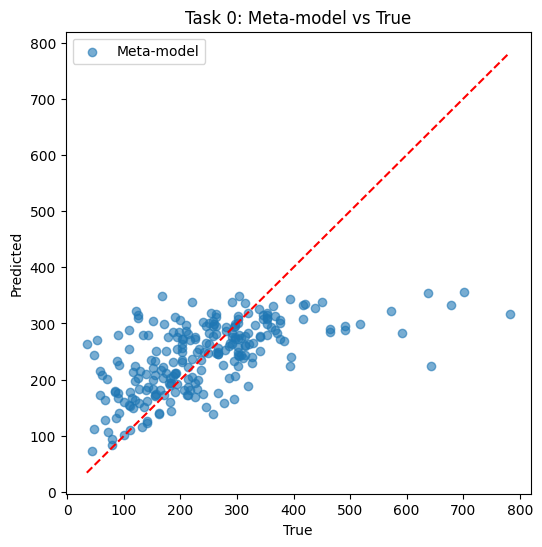

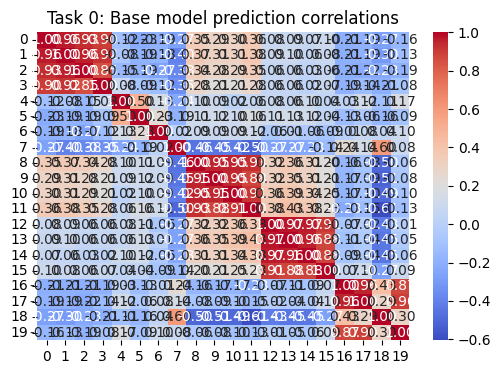


🔹 Task 1
Base models correlation with true labels: [-0.056 -0.161 -0.096 -0.095  0.121 -0.057 -0.01   0.31  -0.025 -0.037
 -0.033 -0.052 -0.142 -0.084 -0.139 -0.126 -0.07  -0.115  0.009 -0.1  ]
Meta-model correlation: 0.396, RMSE: 2.771
Meta-model coefficients: [ 0.239 -0.276  0.07  -0.    -0.    -0.164 -0.     0.828  0.    -0.
  0.    -0.    -0.199 -0.    -0.054 -0.    -0.041 -0.    -0.    -0.214]


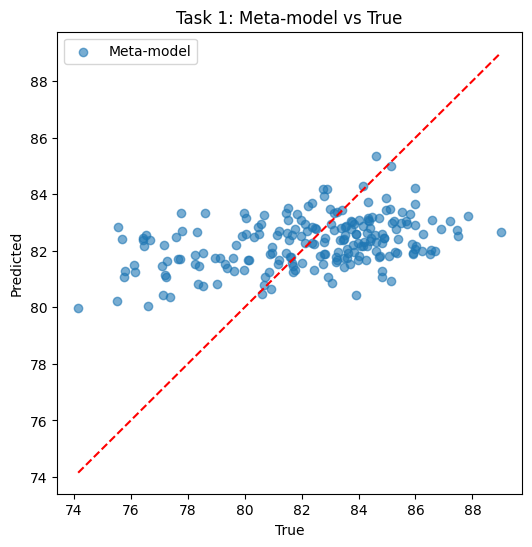

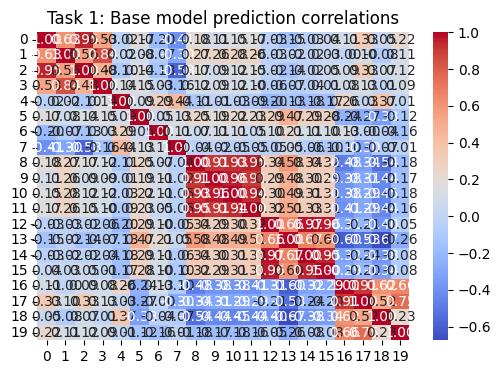


🔹 Task 2
Base models correlation with true labels: [ 0.306  0.387  0.291  0.25  -0.241 -0.025  0.085  0.017  0.668  0.796
  0.778  0.875  0.296  0.318  0.374  0.276 -0.    -0.306 -0.026 -0.067]
Meta-model correlation: 0.905, RMSE: 3.636
Meta-model coefficients: [ 0.     0.     0.885 -0.169  0.155 -0.334 -0.487 -0.147 -2.891  1.5
 -2.438 10.317 -0.787  1.631  0.     0.    -0.051 -0.167  0.     0.   ]


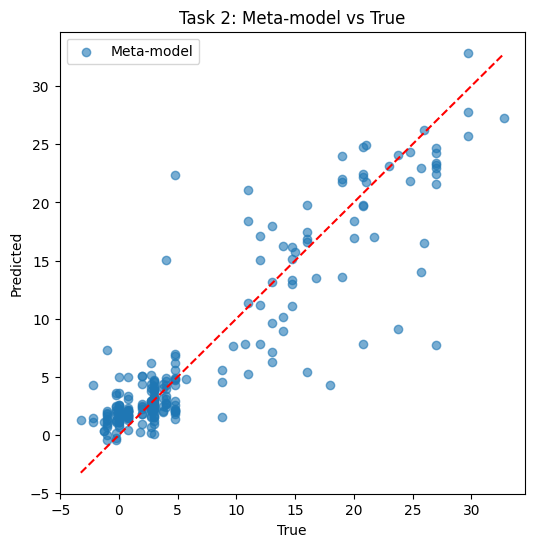

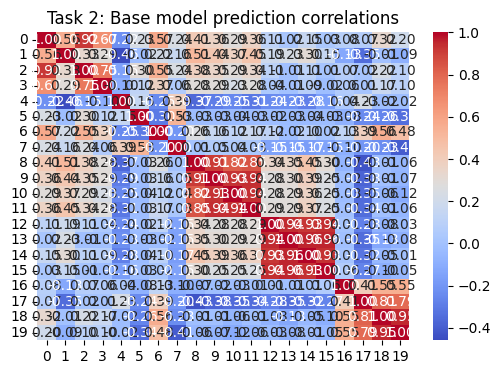


🔹 Task 3
Base models correlation with true labels: [ 0.028  0.048  0.007 -0.003 -0.112 -0.002 -0.058 -0.078  0.318  0.305
  0.329  0.303  0.683  0.766  0.656  0.811 -0.12   0.051 -0.082  0.098]
Meta-model correlation: 0.833, RMSE: 0.138
Meta-model coefficients: [ 0.018  0.009 -0.037 -0.022  0.012  0.    -0.008 -0.005  0.024 -0.035
 -0.     0.027  0.021 -0.001 -0.028  0.207  0.039 -0.007 -0.05   0.025]


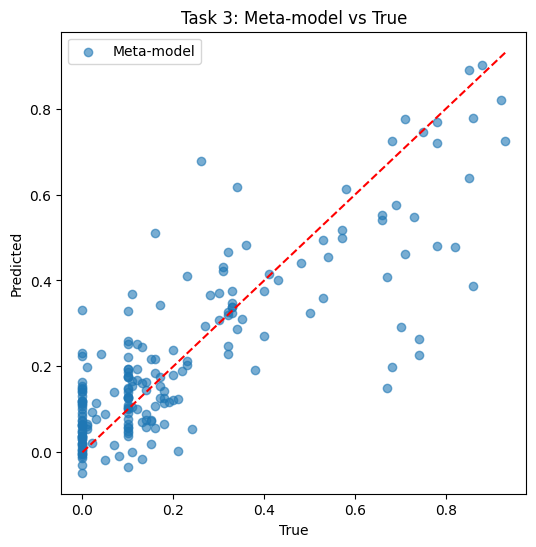

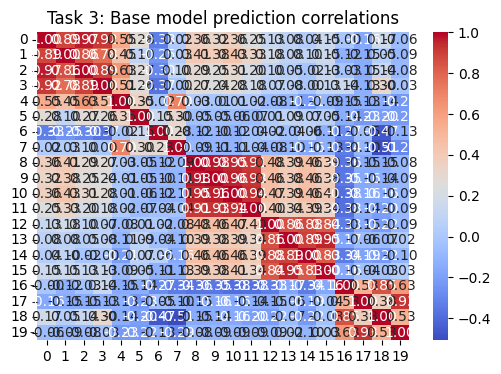


🔹 Task 4
Base models correlation with true labels: [-0.016  0.006  0.05  -0.055  0.026 -0.08   0.095 -0.11  -0.094 -0.094
 -0.086 -0.092  0.058  0.075  0.005  0.083  0.638  0.698  0.293  0.824]
Meta-model correlation: 0.840, RMSE: 0.183
Meta-model coefficients: [ 0.013  0.006 -0.003 -0.019  0.016 -0.005  0.002  0.009 -0.023 -0.005
 -0.01   0.017 -0.029  0.035  0.014 -0.006 -0.086  0.068  0.007  0.285]


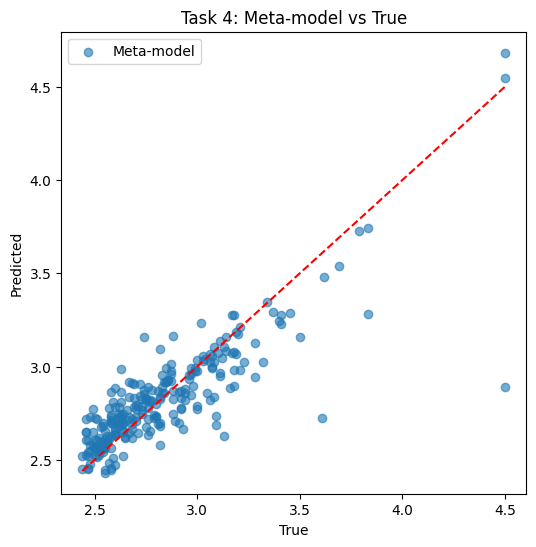

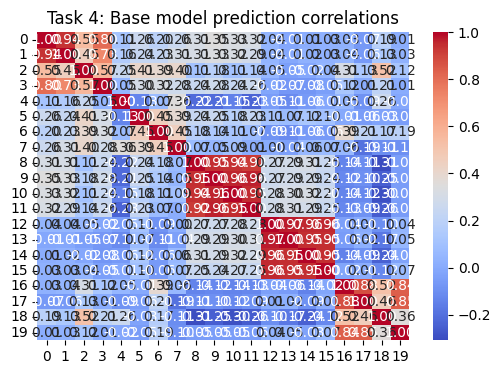

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

num_tasks = 5

for task in range(num_tasks):
    print(f"\n🔹 Task {task}")

    # Get true labels
    y_val = np.load("../data/all_data.npy")[:, task]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    # Stack OOF predictions from all base models
    val_preds = np.stack(val_preds_dict[task])   # (num_models_total, N_val)
    X_val = val_preds.T[y_mask]

    # Meta-model trained on full validation set
    best_params = task_best_params[task]
    if best_params["model_type"] == "ridge":
        final_model = make_pipeline(StandardScaler(), Ridge(
            alpha=best_params["alpha"],
            fit_intercept=best_params["fit_intercept"],
            solver=best_params["solver"]
        ))
    else:
        final_model = make_pipeline(StandardScaler(), ElasticNet(
            alpha=best_params["alpha"],
            l1_ratio=best_params["l1_ratio"],
            fit_intercept=best_params["fit_intercept"],
            max_iter=10000
        ))
    final_model.fit(X_val, y_val)

    # Meta-model predictions on validation
    meta_val_preds = final_model.predict(X_val)

    # Base model correlations
    base_corrs = [np.corrcoef(X_val[:, i], y_val)[0, 1] for i in range(X_val.shape[1])]
    print(f"Base models correlation with true labels: {np.round(base_corrs, 3)}")

    # Meta-model correlation
    meta_corr = np.corrcoef(meta_val_preds, y_val)[0, 1]
    meta_rmse = np.sqrt(np.mean((meta_val_preds - y_val)**2))
    print(f"Meta-model correlation: {meta_corr:.3f}, RMSE: {meta_rmse:.3f}")

    # Ridge coefficients
    if best_params["model_type"] == "ridge":
        coefs = final_model.named_steps["ridge"].coef_
    else:
        coefs = final_model.named_steps["elasticnet"].coef_
    print(f"Meta-model coefficients: {np.round(coefs, 3)}")

    # Plot base model vs meta-model predictions
    plt.figure(figsize=(6, 6))
    plt.scatter(y_val, meta_val_preds, alpha=0.6, label='Meta-model')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Task {task}: Meta-model vs True")
    plt.legend()
    plt.show()

    # Heatmap of base model correlations
    plt.figure(figsize=(6, 4))
    sns.heatmap(np.corrcoef(X_val.T), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Task {task}: Base model prediction correlations")
    plt.show()


In [97]:
import numpy as np
import pandas as pd

num_tasks = 5
summary = []

for task in range(num_tasks):
    # True labels
    y_val = np.load("all_data.npy")[:, task]
    y_mask = ~np.isnan(y_val)
    y_val = y_val[y_mask]

    # Base model predictions
    val_preds = np.stack(val_preds_dict[task])
    X_val = val_preds.T[y_mask]

    # Meta-model
    best_params = task_best_params[task]
    if best_params["model_type"] == "ridge":
        final_model = make_pipeline(StandardScaler(), Ridge(
            alpha=best_params["alpha"],
            fit_intercept=best_params["fit_intercept"],
            solver=best_params["solver"]
        ))
    else:
        final_model = make_pipeline(StandardScaler(), ElasticNet(
            alpha=best_params["alpha"],
            l1_ratio=best_params["l1_ratio"],
            fit_intercept=best_params["fit_intercept"],
            max_iter=10000
        ))
    final_model.fit(X_val, y_val)

    # Meta-model predictions
    meta_val_preds = final_model.predict(X_val)

    # Base model correlations
    base_corrs = [np.corrcoef(X_val[:, i], y_val)[0, 1] for i in range(X_val.shape[1])]
    best_base_corr = np.max(base_corrs)

    # Meta-model stats
    meta_corr = np.corrcoef(meta_val_preds, y_val)[0, 1]
    meta_rmse = np.sqrt(np.mean((meta_val_preds - y_val)**2))

    # Ridge coefficients
    if best_params["model_type"] == "ridge":
        coefs = final_model.named_steps["ridge"].coef_
    else:
        coefs = final_model.named_steps["elasticnet"].coef_
    coef_max, coef_min = np.max(coefs), np.min(coefs)

    # Append to summary
    summary.append({
        "Task": task,
        "Best Base Corr": round(best_base_corr, 3),
        "Meta Corr": round(meta_corr, 3),
        "Meta RMSE": round(meta_rmse, 3),
        "Coef Max": round(coef_max, 3),
        "Coef Min": round(coef_min, 3)
    })

# Create DataFrame
summary_df = pd.DataFrame(summary)
print(summary_df)
summary_df.to_csv("../outputs/meta_ensemble_summary.csv", index=False)
print("✅ Saved summary table: outputs/meta_ensemble_summary.csv")


   Task  Best Base Corr  Meta Corr  Meta RMSE  Coef Max  Coef Min
0     0           0.584      0.597     98.841    21.608    -4.239
1     1           0.310      0.396      2.771     0.828    -0.276
2     2           0.875      0.905      3.636    10.317    -2.891
3     3           0.811      0.833      0.138     0.207    -0.050
4     4           0.824      0.840      0.183     0.285    -0.086
✅ Saved summary table: meta_ensemble_summary.csv


In [98]:
summary_df

,Task,Best Base Corr,Meta Corr,Meta RMSE,Coef Max,Coef Min
0,0,0.584,0.597,98.841,21.608,-4.239
1,1,0.310,0.396,2.771,0.828,-0.276
2,2,0.875,0.905,3.636,10.317,-2.891
3,3,0.811,0.833,0.138,0.207,-0.050
4,4,0.824,0.840,0.183,0.285,-0.086


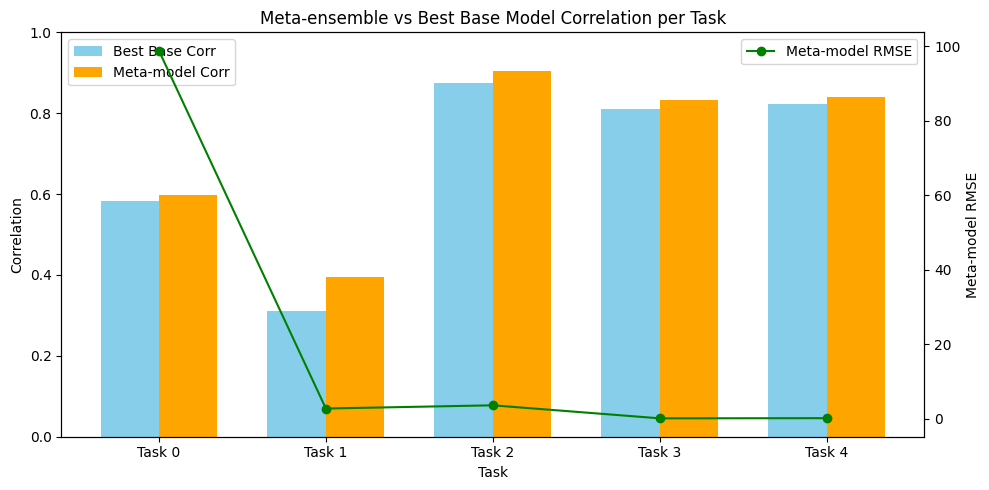

In [99]:
import matplotlib.pyplot as plt
import numpy as np

tasks = summary_df["Task"]
best_base_corr = summary_df["Best Base Corr"]
meta_corr = summary_df["Meta Corr"]
meta_rmse = summary_df["Meta RMSE"]

x = np.arange(len(tasks))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 5))

# Correlation bars
bars1 = ax1.bar(x - width/2, best_base_corr, width, label='Best Base Corr', color='skyblue')
bars2 = ax1.bar(x + width/2, meta_corr, width, label='Meta-model Corr', color='orange')

ax1.set_xlabel("Task")
ax1.set_ylabel("Correlation")
ax1.set_xticks(x)
ax1.set_xticklabels([f"Task {t}" for t in tasks])
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax1.set_title("Meta-ensemble vs Best Base Model Correlation per Task")

# RMSE line (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(x, meta_rmse, color='green', marker='o', label='Meta-model RMSE')
ax2.set_ylabel("Meta-model RMSE")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
